In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from models import U_Net_big
from RectifiedFlow import RectifiedFlow_Unet, train

from util import load_MNIST, show_samples, show_trajectories

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 512
train_dataset, test_dataset, train_dataloader, test_dataloader, classes = load_MNIST(batch_size)
input_shape = (batch_size, 2, 32, 32)

def get_samples(shape, device):
    return torch.randn(shape, device=device)

In [4]:
v_model_1 = U_Net_big(input_shape=input_shape, output_channels=1, device=device)
rectified_flow_1 = RectifiedFlow_Unet(v_model_1, device)

In [5]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=1e-3)
scheduler_1 = None # optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=80, verbose=True)

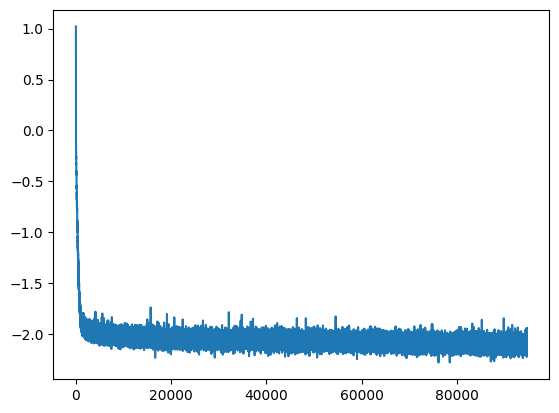

In [7]:
rectified_flow_1 = train(rectified_flow_1, False, optimizer_1, scheduler_1, train_dataloader, get_samples, device, epochs=800, noise_factor=0.005)
plt.plot(np.log(rectified_flow_1.loss_curve))
plt.show()

In [8]:
torch.save(rectified_flow_1, "./models/MNIST/MNIST_All_Unet.pth")

In [141]:
rectified_flow_1 = torch.load("./models/MNIST/MNIST_All_Unet.pth")

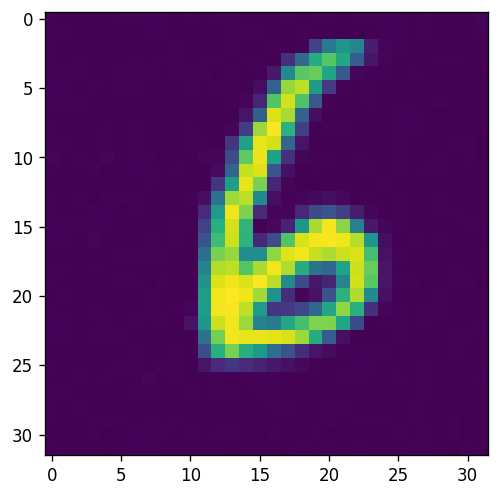

In [166]:
rectified_flow_1.v_model.eval()
img_init = torch.randn(2,1,32,32).to(device)

img = rectified_flow_1.sample_ode(img_init, 100)

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

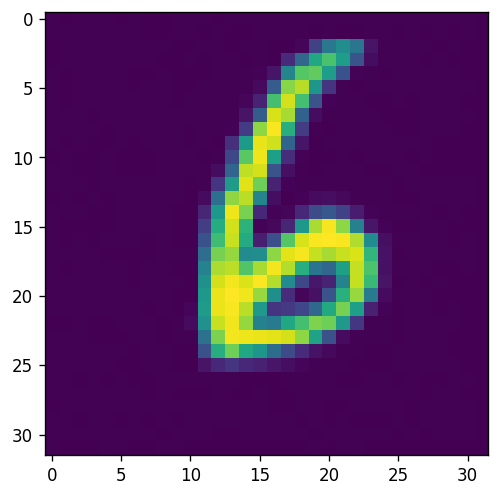

In [173]:
img = rectified_flow_1.sample_ode(img_init, 20)

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

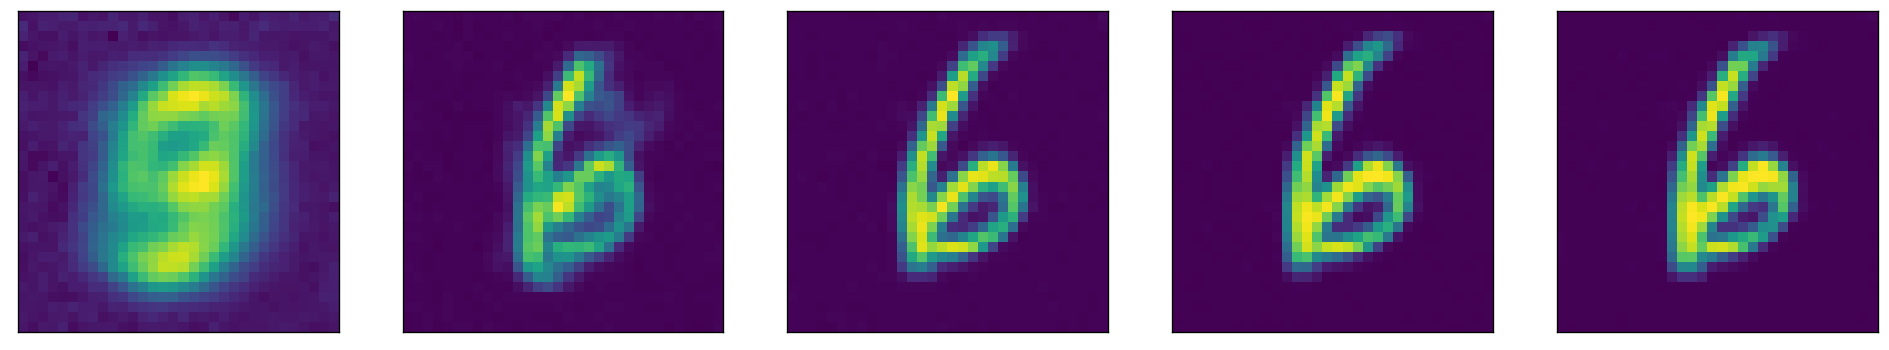

In [177]:
plt.rcParams['figure.dpi'] = 120
rectified_flow_1.v_model.eval()

size = (4*5, 4*1)
fig, ax = plt.subplots(1, 5, figsize=(size),
                        sharex=True, sharey=True)

for row in range(1):
    for column in range(5):
        i = row * 5 + column
        img = rectified_flow_1.sample_ode(img_init, i+1)[-1]
        min = torch.min(img[0])
        img[0] = img[0] - min
        max = torch.max(img[0])
        img[0] = img[0] / max
        ax[column].imshow(
            img[0].permute(1,2,0).detach().cpu().numpy())

plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
samples = [0,0,0,200,0,0,0,0,0,0]

In [167]:
samples[6] = img_init[:1]
for sample in samples:
    print(sample)

tensor([[[[ 0.9375, -1.2797, -1.9427,  ...,  0.6327,  0.1353,  0.3949],
          [ 0.0276,  0.4560, -0.2062,  ...,  0.4278, -2.6911, -1.4483],
          [-0.1761, -0.2068,  0.0320,  ...,  0.8883,  1.1213, -1.8659],
          ...,
          [-0.9525, -1.3963,  0.0622,  ...,  0.8221,  0.1309, -0.0576],
          [ 0.9694, -0.9139,  1.1460,  ..., -1.4975,  0.1004, -0.3728],
          [ 0.8050,  0.9341, -1.1765,  ..., -0.2663, -1.3165, -0.2911]]]],
       device='cuda:0')
tensor([[[[-0.7135, -0.8290,  1.4018,  ...,  0.0364,  0.2482, -1.7617],
          [-1.9803, -0.8343, -1.0952,  ..., -0.1491,  0.4148, -0.5391],
          [ 0.2990,  0.9554, -2.8014,  ..., -0.5713,  0.1817,  1.2450],
          ...,
          [-0.3814, -0.4645,  1.4888,  ...,  0.2164,  0.2807,  0.7891],
          [ 0.7151, -0.5088, -0.2454,  ...,  0.0928, -1.6847,  0.2221],
          [-0.6775,  1.1433,  1.1559,  ..., -0.0280, -1.0075, -0.4750]]]],
       device='cuda:0')
tensor([[[[ 1.4780, -0.1159,  1.2570,  ..., -1.1174,

In [125]:
def show_samples_array(rectified_flow, samples, rows, columns, num_steps, device, conditional=False):
    plt.rcParams['figure.dpi'] = 120
    rectified_flow.v_model.eval()

    size = (4*columns, 4*rows)
    fig, ax = plt.subplots(rows, columns, figsize=(size),
                           sharex=True, sharey=True)

    for row in range(rows):
        for column in range(columns):
            i = row * columns + column
            img = rectified_flow.sample_ode(samples[i], num_steps)[-1]
            min = torch.min(img[0])
            img[0] = img[0] - min
            max = torch.max(img[0])
            img[0] = img[0] / max
            ax[row, column].imshow(
                img[0].permute(1,2,0).detach().cpu().numpy())
    
    plt.xticks([])
    plt.yticks([])
    plt.show()

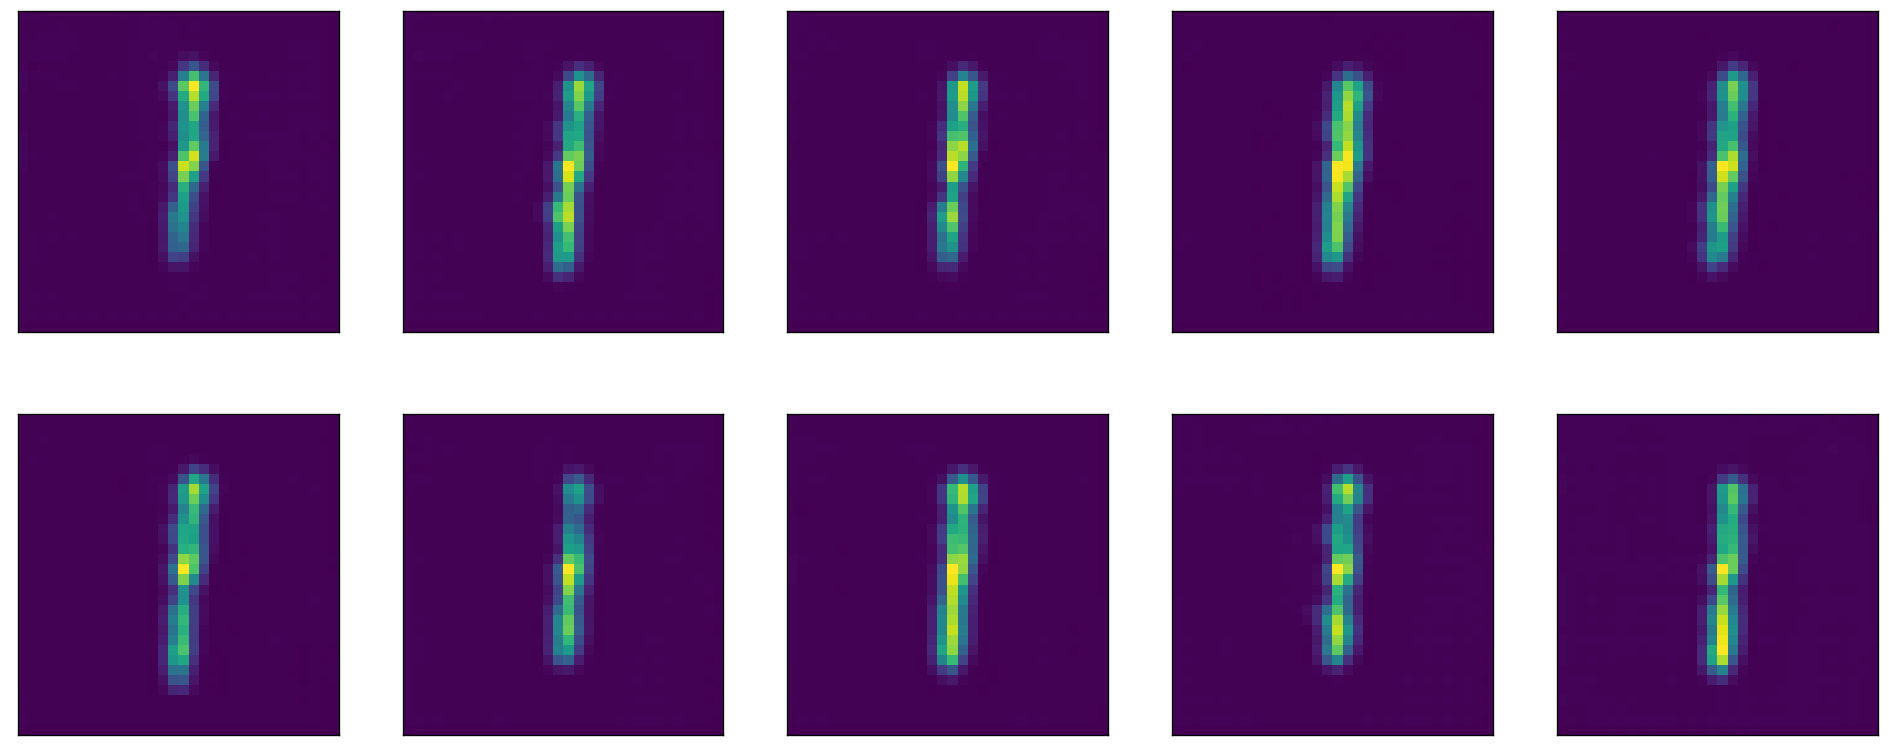

In [144]:
show_samples_array(rectified_flow_1, samples, 2, 5, 100, device)

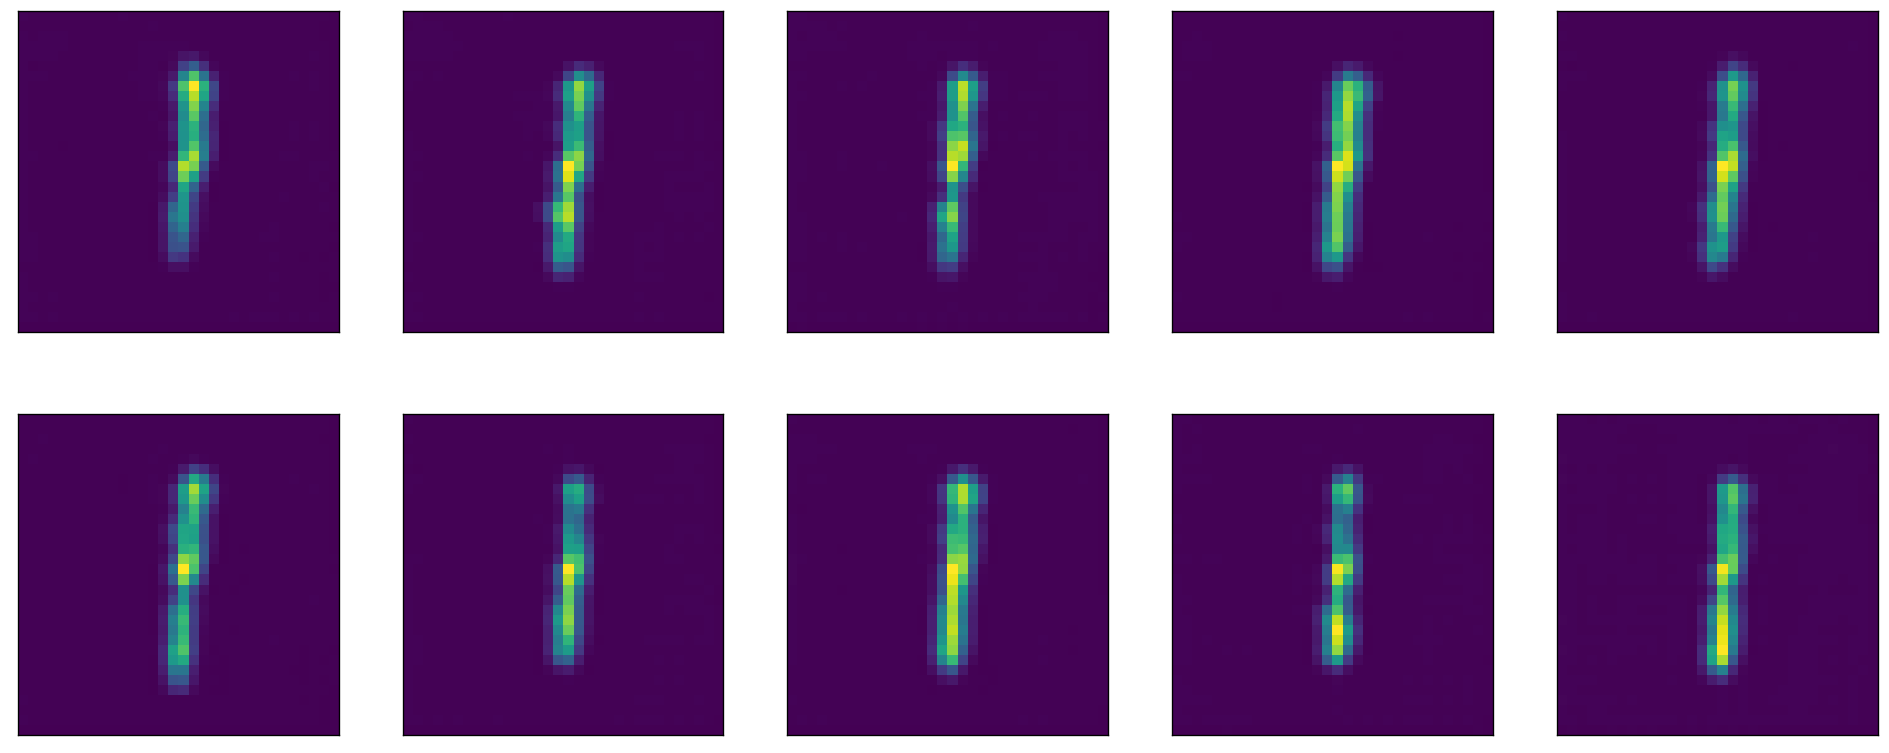

In [126]:
show_samples_array(rectified_flow_1, samples, 2, 5, 100, device)

In [127]:
def show_sample_temperature(rectified_flow, get_samples, rows, columns, channels, img_size, num_steps, device, conditional=False):
    plt.rcParams['figure.dpi'] = 120
    rectified_flow.v_model.eval()
    img_init = get_samples(
        (1, channels, img_size, img_size), device=device)

    size = (4*columns, 4*rows)
    fig, ax = plt.subplots(rows, columns, figsize=(size),
                           sharex=True, sharey=True)

    n = rows * columns

    for row in range(rows):
        for column in range(columns):
            i = row * columns + column
            img = rectified_flow.sample_ode(img_init * (1/n) * i, num_steps)[-1]
            min = torch.min(img[0])
            img[0] = img[0] - min
            max = torch.max(img[0])
            img[0] = img[0] / max
            ax[row, column].imshow(
                img[0].permute(1,2,0).detach().cpu().numpy())
    
    plt.xticks([])
    plt.yticks([])
    plt.show()

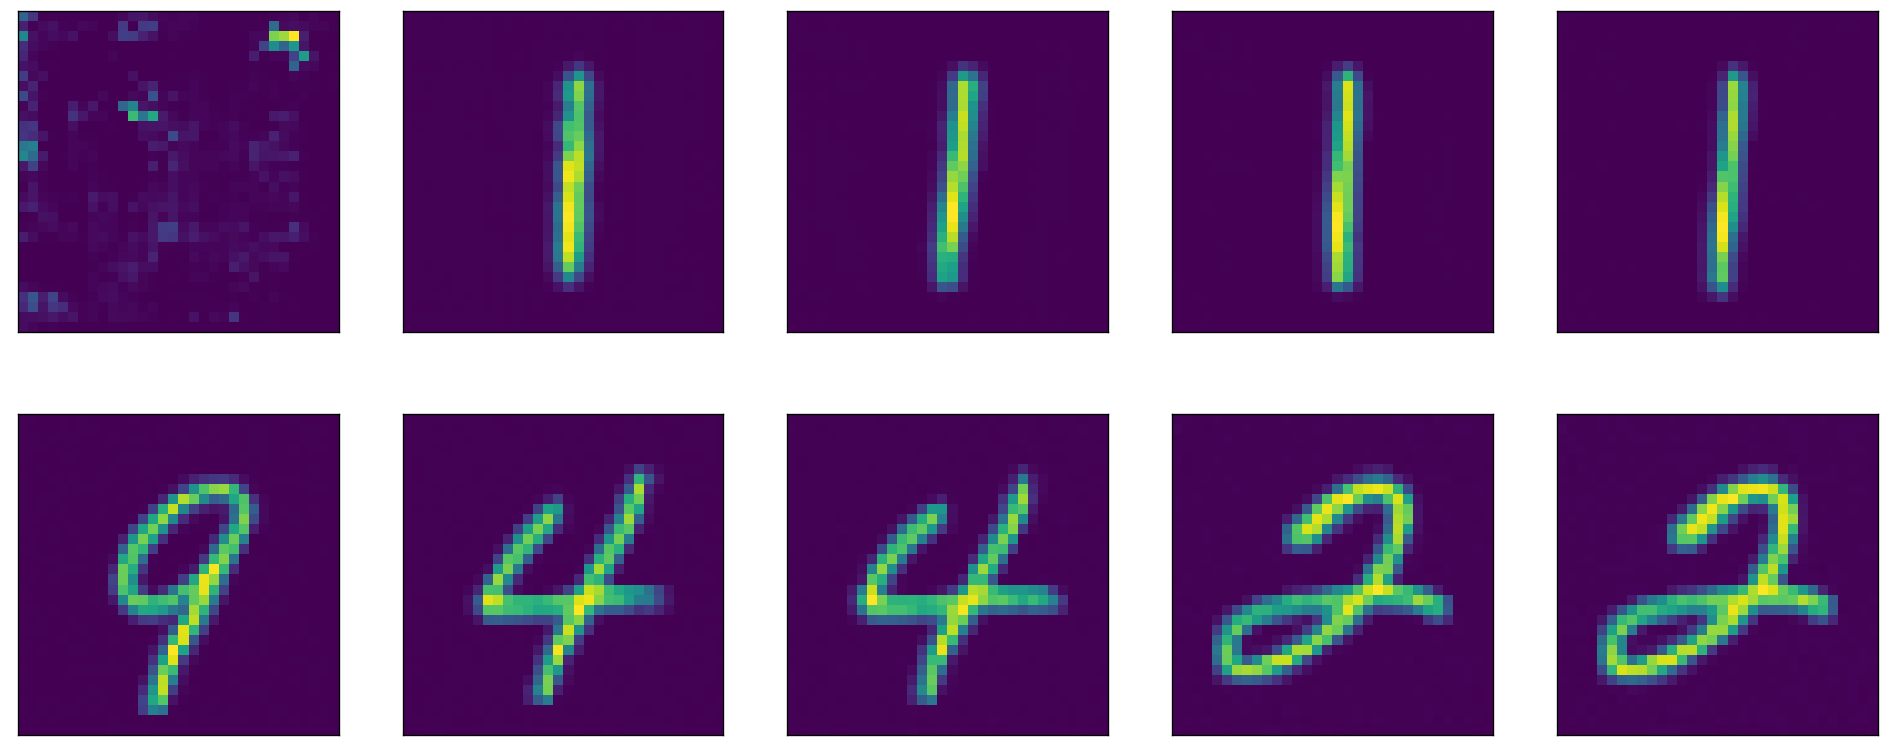

In [134]:
show_sample_temperature(rectified_flow_1, get_samples, 2, 5, 1, 32, 100, device)

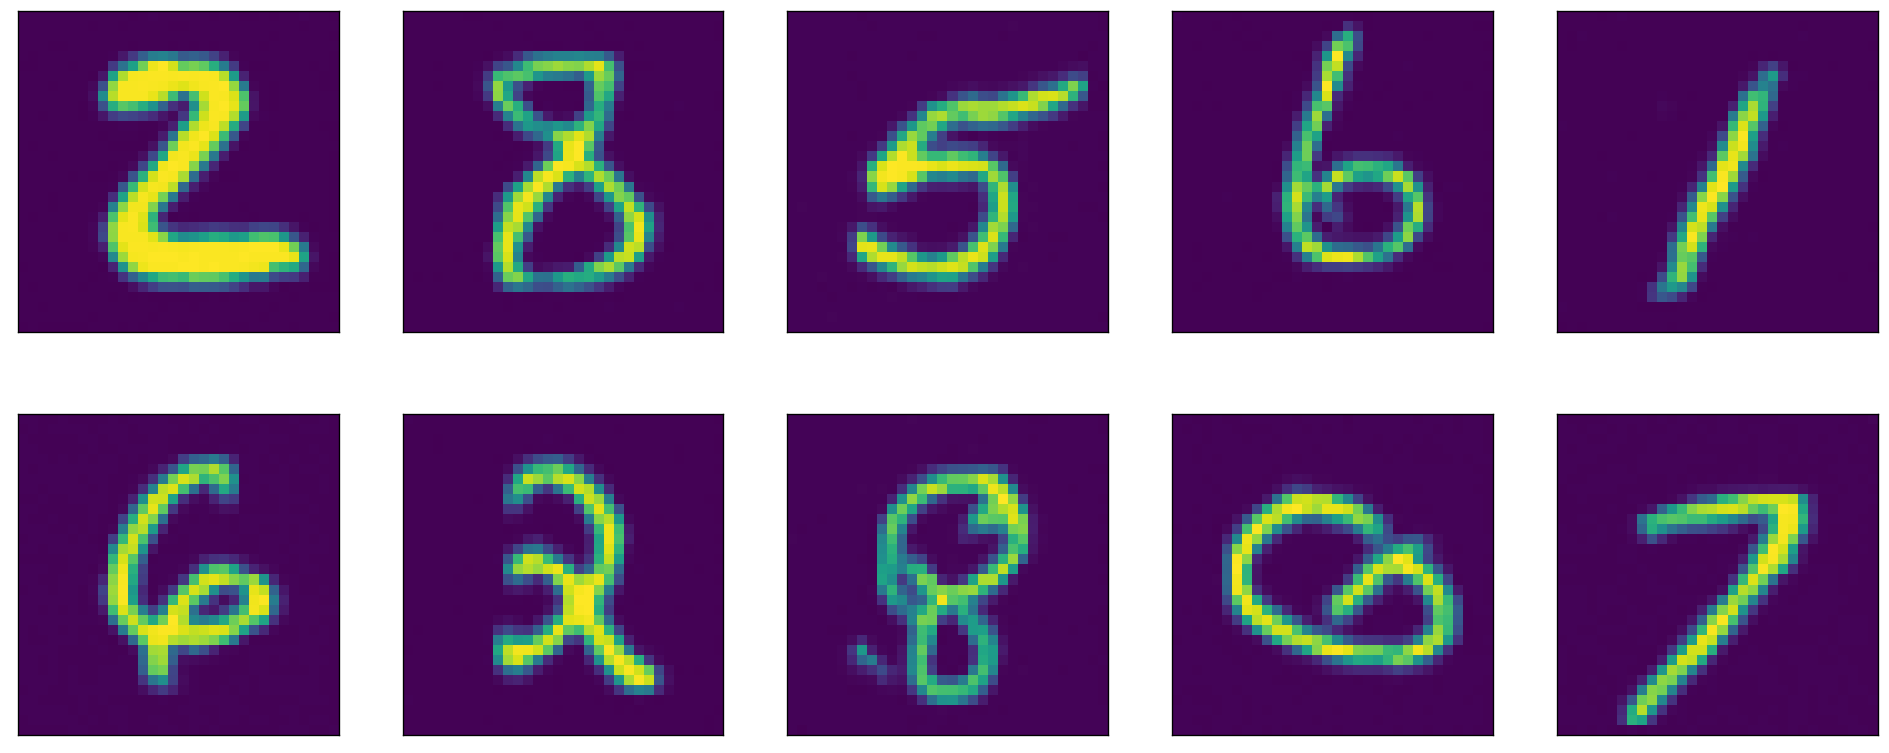

In [151]:
show_samples(rectified_flow_1, get_samples, rows=2, columns=5, channels=1, img_size=32, num_steps=10, device=device)

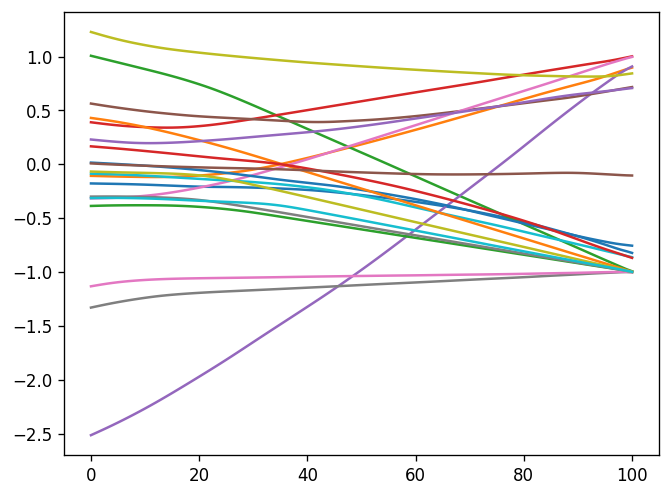

In [135]:
show_trajectories(rectified_flow_1, get_samples, img_size=32, num_steps=100, device=device)

[]

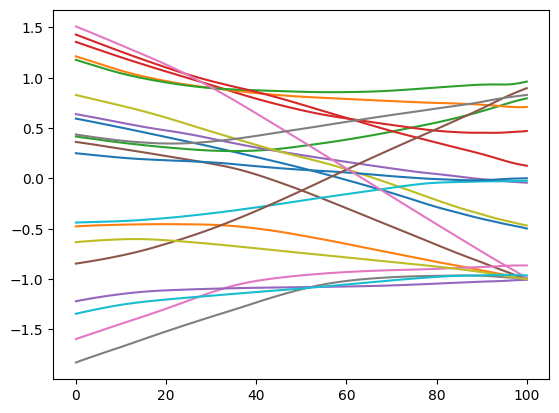

In [11]:
s = torch.zeros(20,len(img),1,32,32)
for i in range(len(img)):
    s[:,i] = img[i]
for i in range(20):
    plt.plot(s[i,:,0,18,13].cpu().numpy())
plt.plot()

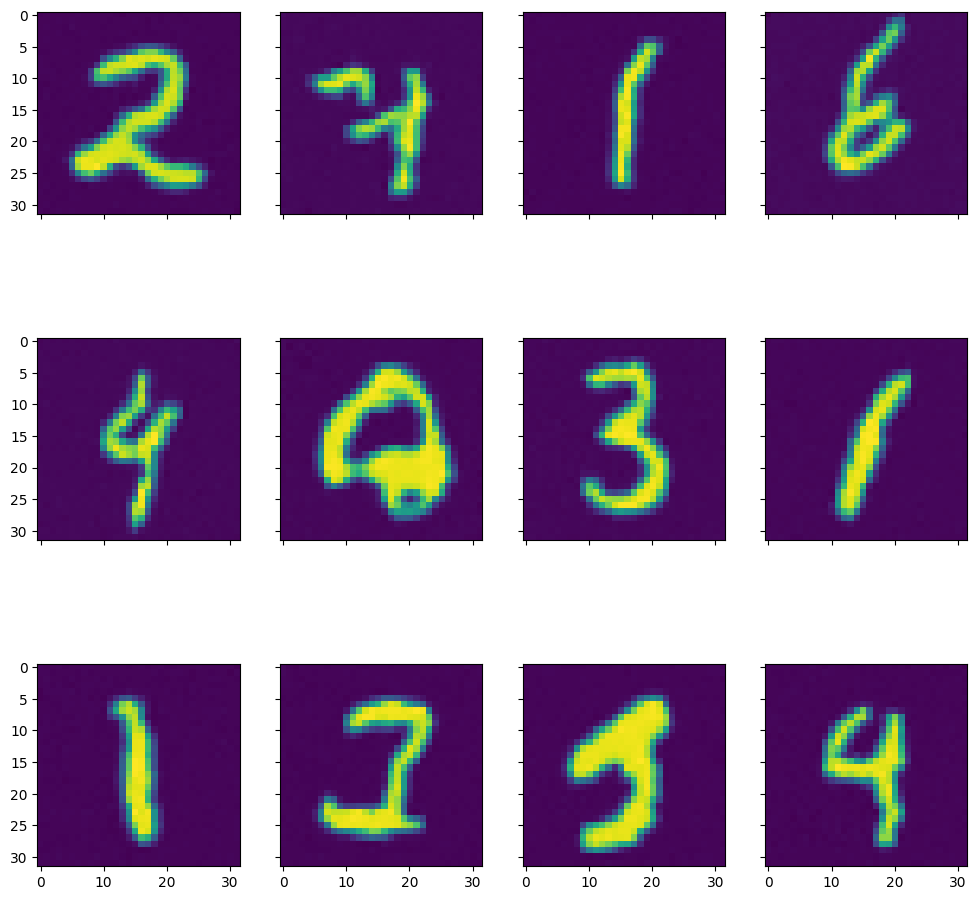

In [24]:
rows = 3
columns = 4
size = (12, 12)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

img_init = torch.randn(rows*columns,1,32,32).to(device)
img = rectified_flow_1.sample_ode(img_init, 100)[-1].detach().cpu().numpy()

i = 0
for row in range(rows):
    for column in range(columns):
        ax[row, column].imshow(img[i,0])
        i += 1

plt.show()

In [22]:
samples_init = torch.randn(2000,1,32,32).to(device) / 3 # do this sampeling in batches ?
flow_1 = rectified_flow_1.sample_ode(samples_init, 100)

RuntimeError: CUDA out of memory. Tried to allocate 500.00 MiB (GPU 0; 7.79 GiB total capacity; 4.95 GiB already allocated; 84.75 MiB free; 6.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
v_model_2 = U_Net(input_shape=input_shape, output_channels=1, initial_lr=5e-3, momentum=0.9, weight_decay=0.0)
rectified_flow_2 = RectifiedFlow_Unet(v_model_2, device)

In [ ]:
optimizer_2 = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)
# optim.beta1 = 0.9
# optim.eps = 1e-8
#optimizer_1 = torch.optim.SGD(rectified_flow_1.v_model.parameters(), lr=5e-3, momentum=0.99)
scheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, factor=0.8, patience=80, verbose=True)

In [ ]:
rectified_flow_2 = train_rectified_flow_Unet(rectified_flow_2, optimizer_2, scheduler_2, train_dataloader, device, epochs=60)

Epoch 00551: reducing learning rate of group 0 to 4.0000e-03.
Epoch 00652: reducing learning rate of group 0 to 3.2000e-03.
Epoch 00763: reducing learning rate of group 0 to 2.5600e-03.
Epoch 00880: reducing learning rate of group 0 to 2.0480e-03.
Epoch 00961: reducing learning rate of group 0 to 1.6384e-03.
Epoch 01042: reducing learning rate of group 0 to 1.3107e-03.
Epoch 01123: reducing learning rate of group 0 to 1.0486e-03.
Epoch 01278: reducing learning rate of group 0 to 8.3886e-04.
Epoch 01359: reducing learning rate of group 0 to 6.7109e-04.
Epoch 01440: reducing learning rate of group 0 to 5.3687e-04.
Epoch 01521: reducing learning rate of group 0 to 4.2950e-04.
Epoch 01602: reducing learning rate of group 0 to 3.4360e-04.
Epoch 01683: reducing learning rate of group 0 to 2.7488e-04.
Epoch 01764: reducing learning rate of group 0 to 2.1990e-04.
Epoch 01930: reducing learning rate of group 0 to 1.7592e-04.
Epoch 02011: reducing learning rate of group 0 to 1.4074e-04.
Epoch 02

In [ ]:
torch.save(rectified_flow_2, "./models/MNIST_newest_ref1.pth")

In [ ]:
rectified_flow_2 = torch.load("./models/MNIST_newest_ref1.pth")

tensor([[[[-0.9930, -1.0088, -1.0064,  ..., -1.0125, -1.0055, -0.9762],
          [-0.9936, -0.9874, -0.9879,  ..., -0.9942, -0.9839, -1.0150],
          [-0.9848, -0.9936, -0.9995,  ..., -0.9833, -1.0040, -0.9976],
          ...,
          [-0.9899, -1.0035, -1.0079,  ..., -1.0005, -0.9994, -0.9871],
          [-0.9933, -1.0009, -1.0023,  ..., -0.9963, -0.9966, -0.9948],
          [-0.9997, -1.0072, -1.0046,  ..., -0.9992, -0.9983, -0.9899]]],


        [[[-0.9801, -1.0077, -1.0098,  ..., -0.9986, -0.9884, -0.9866],
          [-0.9902, -0.9904, -1.0030,  ..., -1.0046, -0.9851, -0.9800],
          [-0.9845, -0.9931, -0.9984,  ..., -1.0118, -0.9973, -0.9819],
          ...,
          [-0.9918, -1.0022, -0.9894,  ..., -1.0016, -1.0048, -0.9975],
          [-0.9836, -0.9842, -0.9955,  ..., -1.0058, -1.0158, -0.9897],
          [-0.9819, -0.9891, -1.0031,  ..., -0.9978, -1.0025, -0.9883]]],


        [[[-0.9782, -1.0020, -0.9904,  ..., -1.0117, -0.9884, -0.9851],
          [-0.9910, -1.013

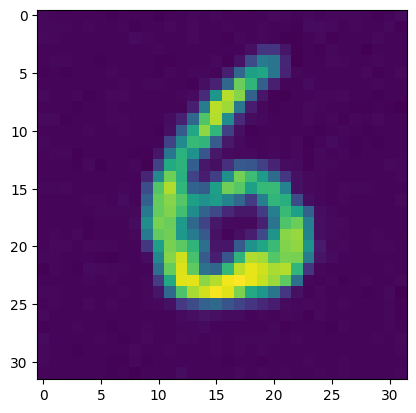

In [ ]:
rectified_flow_2.v_model.eval()
img_init = torch.randn(20,1,32,32).to(device) / 3

img = rectified_flow_2.sample_ode(img_init, 3)

print(img[-1])

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

[]

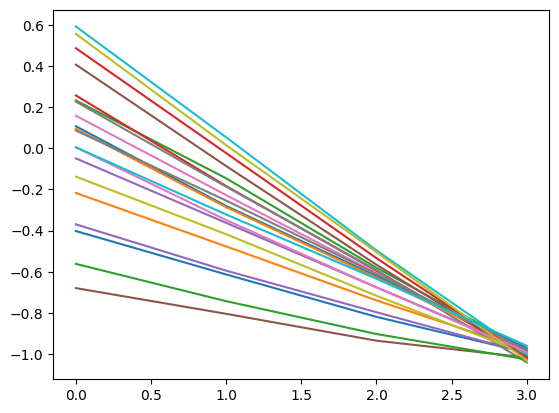

In [ ]:
s = torch.zeros(20,len(img),1,32,32)
for i in range(len(img)):
    s[:,i] = img[i]
for i in range(20):
    plt.plot(s[i,:,0,0,0].cpu().numpy())
plt.plot()

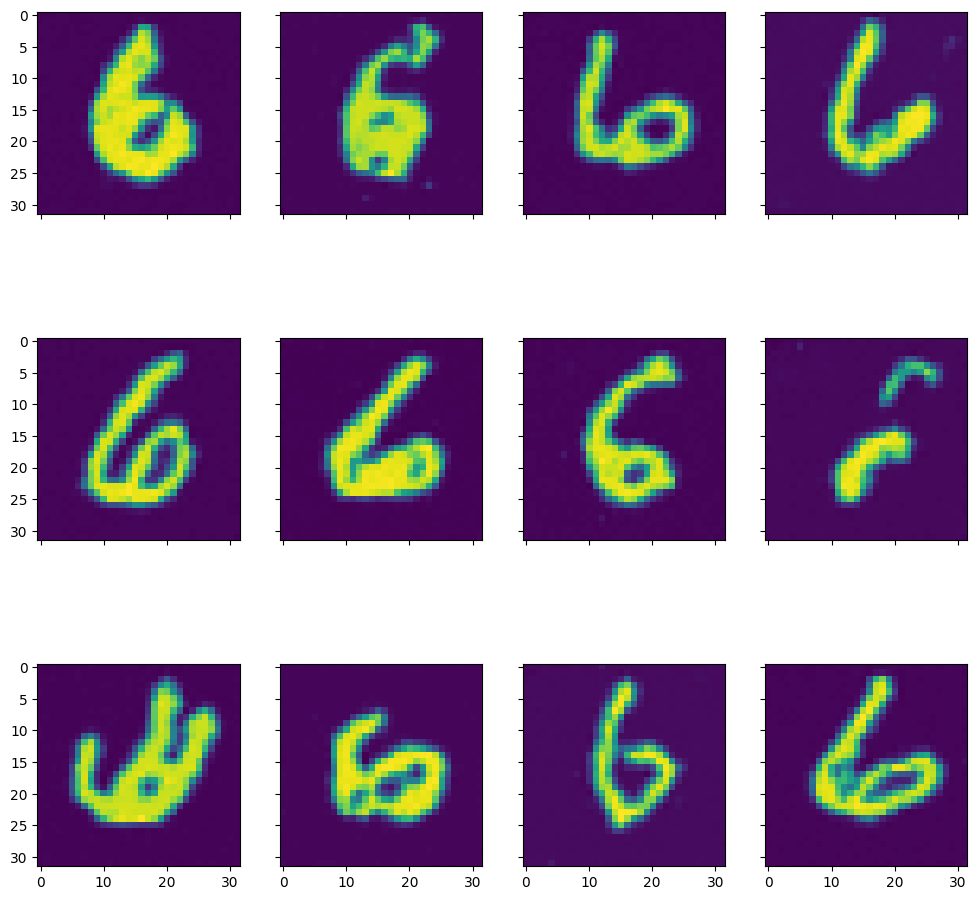

In [ ]:
rows = 3
columns = 4
size = (12, 12)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

for row in range(rows):
    for column in range(columns):
        img_init = torch.randn(1,1,32,32).to(device) / 3

        img = rectified_flow_2.sample_ode(img_init, 100)[-1][0,0].detach().cpu().numpy()
        ax[row, column].imshow(img)

plt.show()

In [ ]:
def show_trajectories(rectified_flow):
    rectified